
A notebook for GAN trying
==============
    
<font color=#000000 size=3 face="黑体">  This notebook can be used to test and train a GAN to discriminate mnist data
The following part is providing basic setting(like class defination)

In [18]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
#  the progression of the generator

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
import torchvision
%matplotlib inline
nz=128
ngf=64
ndf=64
nc=1
batch_size = 128
# Number of training epochs
num_epochs = 5
fixed_noise = torch.randn(64, nz, 1, 1)
# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
img_list = []
G_losses = []
D_losses = []
iters = 0
class PictureDataset(torch.utils.data.Dataset):
    """Face Landmarks dataset."""

    def __init__(self, img_tensor,img_labels):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.img= img_tensor
        self.labels = img_labels

    def __len__(self):
        return int(self.img.shape[0])

    def __getitem__(self, idx):
        img=self.img[idx].reshape((-1,28,28))
        img=(img-torch.mean(img))/torch.pow(torch.var(img),0.5)
        labels=self.labels[idx]

        return (img,labels)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 1, 1, 2, bias=False),
            nn.Tanh()
            # state size. (nc) x 28 x 28
        )

    def forward(self, input):
        return self.main(input)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 28 x 28
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 14 x 14
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 7 x 7
            nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 2 x 2
            nn.Conv2d(ndf * 8, 1, 4, 1, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
netD=torch.load('netD1.pkl')
netG=torch.load('netG1.pkl')
spell_data=torchvision.datasets.EMNIST(root='./emnist/', train=True,transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]),split='letters',download=False)
spell_data=PictureDataset(spell_data.train_data.float(),spell_data.train_labels.float())
spell_data.img.reshape((-1,28,28))
dataloader_spell = torch.utils.data.DataLoader(spell_data, batch_size=batch_size,
                                         shuffle=True, num_workers=0)
train_data=torchvision.datasets.MNIST(root='./mnist/', train=True,transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]),download=False)
train_data=PictureDataset(train_data.train_data.float(),train_data.train_labels.float())
train_data.img.reshape((-1,28,28))
dataloader_train = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                         shuffle=True, num_workers=0)

Random Seed:  999


The second part provide a function for testing picture.  
It take root dir of testing picture and netD as input.File should be placed as following structure:'./folder1/folder2/img'  
The out put of this function is the mean value of the netD output on the folder

In [21]:
def standard_test_piv(root,netD):
    data_jf=torchvision.datasets.ImageFolder(root=root,
                                        transform=transforms.Compose([
                               transforms.ToTensor(),
                                #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
    data_list=[]
    for item in data_jf:
        data_list.append(item[0][0].tolist())
    data_test=torch.FloatTensor(np.array(data_list))
    test_data=PictureDataset(data_test,torch.FloatTensor(np.array(range(len(data_list)))))
    dataloader_test= torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                             shuffle=True, num_workers=0)
    for data in dataloader_test:
        ############################
        # (3) Test D network with Emnist
        ###########################
        ## Train with all-false batch
        # Format batch
        fake = data[0]
        b_size = fake.size(0)
        label = torch.full((b_size,), fake_label)
        # Forward pass real batch through D
        output = netD(fake).view(-1)
        D_x = output.mean().item()
        print(D_x)

In [22]:
standard_test_piv('./mytestimg/',netD)

8.687513286531612e-07


The following part of this notebook give you the chance to train a GAN by yourself

In [10]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
netD = Discriminator()
netG = Generator()
'''
if you want to use the trained data
use the folowing code:
torch.load(netD, 'netD.tar')
torch.load(netG,'netGG.tar')
'''
netG.apply(weights_init)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [11]:
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0
lr=0.0002
# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [12]:
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader_train, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real = data[0]
        b_size = real.size(0)
        label = torch.full((b_size,), real_label)
        # Forward pass real batch through D
        output = netD(real).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()
        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1)
        # Generate fake image batch with G
        fake = netG(noise)
        fake=(fake-torch.mean(fake))/torch.pow(torch.var(fake),0.5)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 5 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader_train),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 20 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader_train)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

Starting Training Loop...


KeyboardInterrupt: 

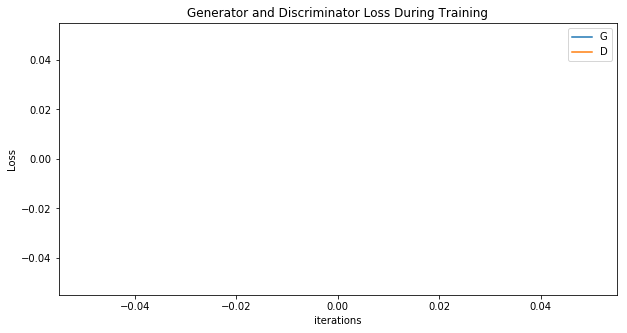

In [13]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

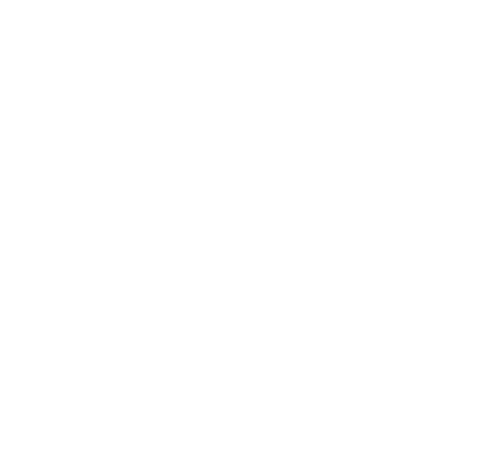

In [14]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

IndexError: list index out of range

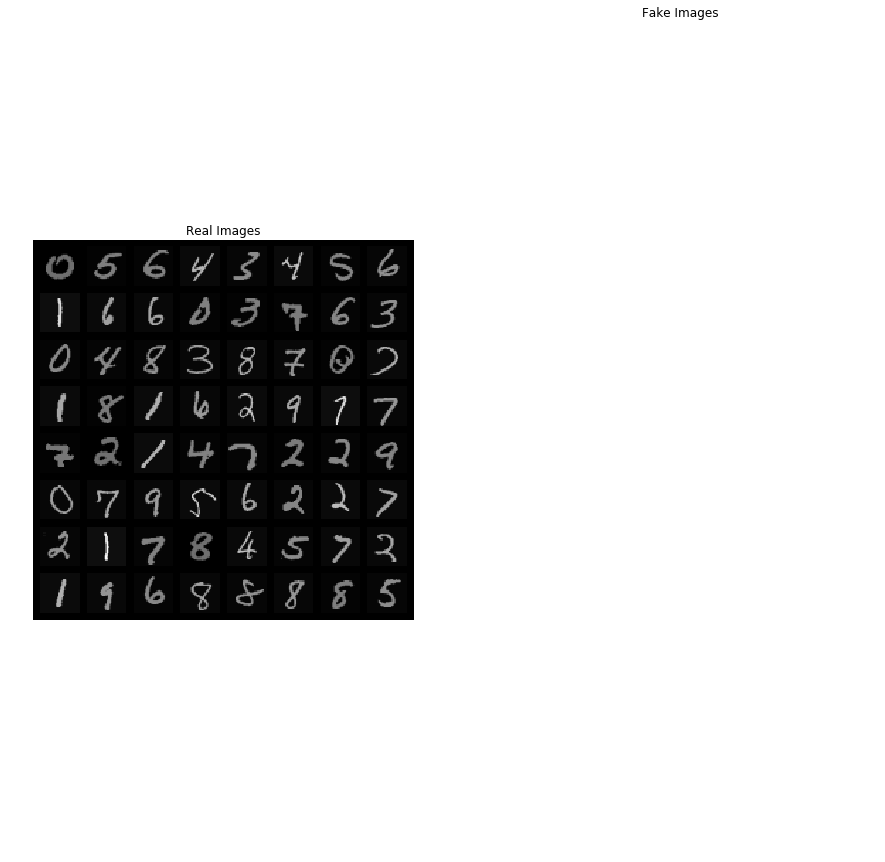

In [15]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader_train))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=5, normalize=True),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

The following part are testing this netD using alphabet picture

In [17]:
for data in dataloader_spell:
    ############################
    # (3) Test D network with Emnist
    ###########################
    ## Train with all-false batch
    netD.zero_grad()
    # Format batch
    fake = data[0]
    b_size = real.size(0)
    label = torch.full((b_size,), fake_label)
    # Forward pass real batch through D
    output = netD(fake).view(-1)
    D_x = output.mean().item()
    print(D_x)

0.8015519976615906
0.8173303604125977
0.8164968490600586
0.8162963390350342
0.8377541303634644
0.8058409690856934
0.8140683770179749
0.7969713807106018
0.7792103290557861
0.8049823641777039
0.8009465932846069
0.8063123822212219
0.8024657368659973


KeyboardInterrupt: 